# 🧪 Expérimentations - Apprentissage par renforcement
Dans ce notebook, nous comparons plusieurs algorithmes (Monte Carlo, Q-Learning, Expected SARSA, Dyna-Q, Dyna-Q+)
sur des environnements comme Monty Hall Level 1.

## Imports

In [35]:
import argparse
import os
import sys
import json
import numpy as np

import matplotlib.pyplot as plt

# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

# === Environnements ===
from secret_envs_wrapper import SecretEnv0, SecretEnv1, SecretEnv2, SecretEnv3

# === Algorithmes ===
from reinfolearn.algorithm.dp.policy_iteration import policy_iteration
from reinfolearn.algorithm.dp.value_iteration import value_iteration
from reinfolearn.algorithm.mc.mc_on_policy import mc_on_policy_first_visit
from reinfolearn.algorithm.mc.mc_off_policy import mc_off_policy_control
from reinfolearn.algorithm.mc.mc_exploring_starts import mc_exploring_starts
from reinfolearn.algorithm.td.q_learning import q_learning
from reinfolearn.algorithm.td.sarsa import sarsa
from reinfolearn.algorithm.td.expected_sarsa import expected_sarsa
from reinfolearn.algorithm.pn.dyna_q import dyna_q
from reinfolearn.algorithm.pn.dyna_q_plus import dyna_q_plus

# === Utilitaires ===
from reinfolearn.utils.io_utils import save_policy, save_q_table, save_values, save_scores
from reinfolearn.utils.plot_utils import plot_scores, plot_convergence, plot_unified
from reinfolearn.utils.metrics_utils import evaluate_policy_score, summarize_policy_scores

## Fonction utilitaire de visualisation

In [2]:
def plot_convergence(values, title="Convergence", ylabel="Value", save_path=None):
    plot_unified(values, title=title, xlabel="Itération", ylabel=ylabel, save_path=save_path, figsize=(8, 4))

def plot_scores(scores, title="Score par épisode", save_path=None):
    plot_unified(scores, title=title, xlabel="Épisode", ylabel="Score total", save_path=save_path, figsize=(8, 4))

def plot_scores_mavg(scores, window=100, title="Score moyen"):
    plot_unified(scores, title=title, xlabel="Épisodes", ylabel="Score moyen", window=window, figsize=(8, 4))

## Fonction standard d'expérimentation

In [27]:
def get_env(env_name):
    envs = {
        "env0": SecretEnv0(),
        "env1": SecretEnv1(),
        "env2": SecretEnv2(),
        "env3": SecretEnv3(),
    }
    return envs[env_name]

In [ ]:
def run_experiment(env_class, algo_fn, algo_name, env_name, **kwargs):
    env = env_class()

    # create output directory if it doesn't exist
    output_dir = f"outputs/{env_name}/{algo_name}"
    os.makedirs(output_dir, exist_ok=True)

    if algo_name == "policy_iteration":
        policy, V, mean_value_history = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_values(V, f"{output_dir}/values.npy") # Save values for policy iteration
        save_scores(mean_value_history, f"{output_dir}/value_convergence.npy")

        print(f"Politique et valeurs sauvegardées pour {env_name} avec {algo_name}")
        return policy, V, mean_value_history
    elif algo_name == "value_iteration":
        policy, V, delta_history = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_values(V, f"{output_dir}/values.npy") # Save values for value iteration
        save_scores(delta_history, f"{output_dir}/delta_convergence.npy")

        print(f"Politique et valeurs sauvegardées pour {env_name} avec {algo_name}")
        return policy, V, delta_history
    else:
        policy, Q, scores = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_q_table(Q, f"{output_dir}/q_table.pkl") # Save Q-table for TD methods
        save_scores(scores, f"{output_dir}/episode_scores.npy")
    return policy, Q, scores

## Expérimentation

Dans cette section, nous allons exécuter les algorithmes sur différents environnements et collecter les scores. 

### Étude sur l'environnement Env 0

In [34]:
env_name = "env0"
env = get_env(env_name)
env_class = SecretEnv0

print("num_states:", env.num_states())
print("num_actions:", env.num_actions())
print("num_rewards:", env.num_rewards())
for i in range(env.num_rewards()):
    print(env.reward(i))
print(env.p(0, 0, 0, 0))

print("available actions:", env.available_actions())

num_states: 8192
num_actions: 3
num_rewards: 3
-1.0
0.0
1.0
0.0
available actions: [1 2]


8192
3
3
-1.0
0.0
1.0
0.0
[1 2]


In [ ]:
# MC Off-policy
# policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
#     env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
#     nb_episodes=100, gamma=0.99)

# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=1000, gamma=0.99, epsilon=0.01)

# MC Exploring Starts
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=1000, gamma=0.99)

# Q-learning
policy_q, Q_q, scores_q = run_experiment(
    env_class, q_learning, "Q-Learning", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Expected SARSA
policy_esarsa, Q_esarsa, scores_esarsa = run_experiment(
    env_class, expected_sarsa, "Expected SARSA", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# SARSA
policy_sarsa, Q_sarsa, scores_sarsa = run_experiment(
    env_class, sarsa, "SARSA", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Dyna-Q
policy_dq, Q_dq, scores_dq = run_experiment(
    env_class, dyna_q, "Dyna-Q", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20)

# Dyna-Q+
policy_dqplus, Q_dqplus, scores_dqplus = run_experiment(
    env_class, dyna_q_plus, "Dyna-Q+", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20, kappa=1e-4)

Dyna-Q+: 100%|██████████| 1000/1000 [00:33<00:00, 30.06it/s]


#### Comparaison graphique des performances

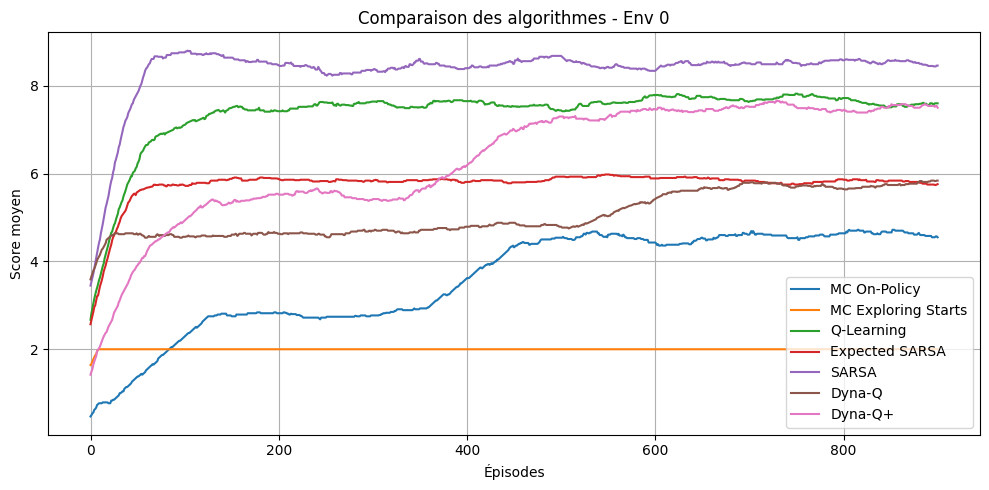

In [6]:
algorithms_data = {
    "MC On-Policy": scores_mc_on_policy,
    "MC Exploring Starts": scores_mc_exploring_starts,
    "Q-Learning": scores_q,
    "Expected SARSA": scores_esarsa,
    "SARSA": scores_sarsa,
    "Dyna-Q": scores_dq,
    "Dyna-Q+": scores_dqplus
}

plot_unified(
    algorithms_data, 
    title="Comparaison des algorithmes - Env 0",
    ylabel="Score moyen",
    window=100
)

### Étude sur l'environnement Env 1

In [7]:
env_name = "Env1"
env_class = SecretEnv1


# MC Off-policy
# policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
#     env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
#     nb_episodes=100, gamma=0.99)

# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=1000, gamma=0.99, epsilon=0.01)

# MC Exploring Starts
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=1000, gamma=0.99)

# Q-learning
policy_q, Q_q, scores_q = run_experiment(
    env_class, q_learning, "Q-Learning", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Expected SARSA
policy_esarsa, Q_esarsa, scores_esarsa = run_experiment(
    env_class, expected_sarsa, "Expected SARSA", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# SARSA
policy_sarsa, Q_sarsa, scores_sarsa = run_experiment(
    env_class, sarsa, "SARSA", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Dyna-Q
policy_dq, Q_dq, scores_dq = run_experiment(
    env_class, dyna_q, "Dyna-Q", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20)

# Dyna-Q+
policy_dqplus, Q_dqplus, scores_dqplus = run_experiment(
    env_class, dyna_q_plus, "Dyna-Q+", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20, kappa=1e-4)

Dyna-Q+: 100%|██████████| 1000/1000 [06:16<00:00,  2.66it/s]


#### Comparaison graphique des performances

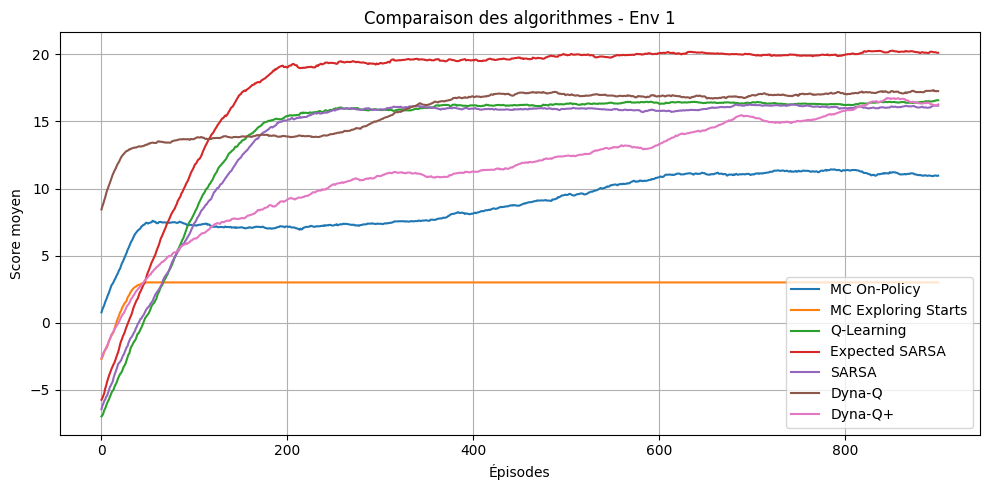

In [8]:
algorithms_data = {
    "MC On-Policy": scores_mc_on_policy,
    "MC Exploring Starts": scores_mc_exploring_starts,
    "Q-Learning": scores_q,
    "Expected SARSA": scores_esarsa,
    "SARSA": scores_sarsa,
    "Dyna-Q": scores_dq,
    "Dyna-Q+": scores_dqplus
}

plot_unified(
    algorithms_data, 
    title="Comparaison des algorithmes - Env 1",
    ylabel="Score moyen",
    window=100
)

### Étude sur l'environnement Env 2

In [9]:
env_name = "Env2"
env_class = SecretEnv2


# MC Off-policy
# policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
#     env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
#     nb_episodes=100, gamma=0.99)

# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=1000, gamma=0.99, epsilon=0.01)

# MC Exploring Starts
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=1000, gamma=0.99)

# Q-learning
policy_q, Q_q, scores_q = run_experiment(
    env_class, q_learning, "Q-Learning", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Expected SARSA
policy_esarsa, Q_esarsa, scores_esarsa = run_experiment(
    env_class, expected_sarsa, "Expected SARSA", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# SARSA
policy_sarsa, Q_sarsa, scores_sarsa = run_experiment(
    env_class, sarsa, "SARSA", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Dyna-Q
policy_dq, Q_dq, scores_dq = run_experiment(
    env_class, dyna_q, "Dyna-Q", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20)

# Dyna-Q+
policy_dqplus, Q_dqplus, scores_dqplus = run_experiment(
    env_class, dyna_q_plus, "Dyna-Q+", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20, kappa=1e-4)

Dyna-Q+: 100%|██████████| 1000/1000 [22:41<00:00,  1.36s/it]


#### Comparaison graphique des performances

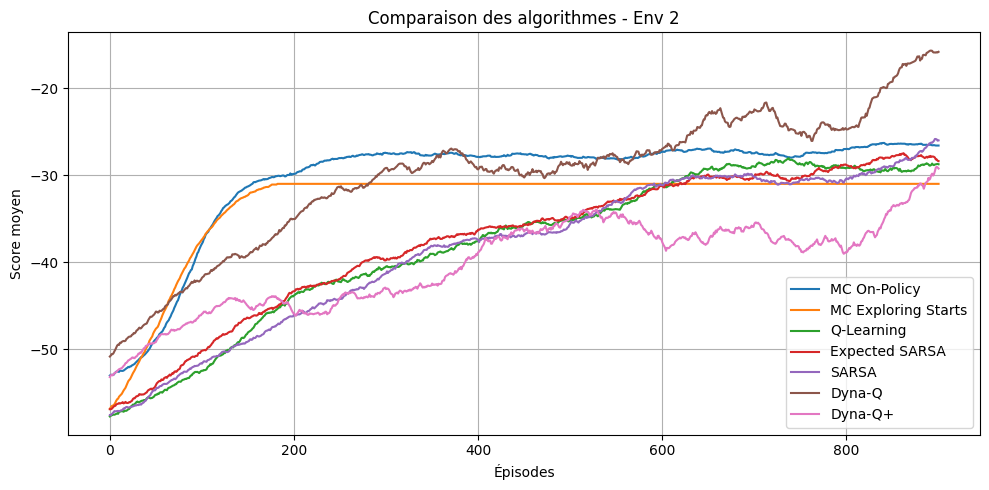

In [10]:
algorithms_data = {
    "MC On-Policy": scores_mc_on_policy,
    "MC Exploring Starts": scores_mc_exploring_starts,
    "Q-Learning": scores_q,
    "Expected SARSA": scores_esarsa,
    "SARSA": scores_sarsa,
    "Dyna-Q": scores_dq,
    "Dyna-Q+": scores_dqplus
}

plot_unified(
    algorithms_data, 
    title="Comparaison des algorithmes - Env 2",
    ylabel="Score moyen",
    window=100
)

### Étude sur l'environnement Env 3

In [11]:
env_name = "Env3"
env_class = SecretEnv3


# MC Off-policy
# policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
#     env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
#     nb_episodes=100, gamma=0.99)

# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=1000, gamma=0.99, epsilon=0.01)

# MC Exploring Starts
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=1000, gamma=0.99)

# Q-learning
policy_q, Q_q, scores_q = run_experiment(
    env_class, q_learning, "Q-Learning", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Expected SARSA
policy_esarsa, Q_esarsa, scores_esarsa = run_experiment(
    env_class, expected_sarsa, "Expected SARSA", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# SARSA
policy_sarsa, Q_sarsa, scores_sarsa = run_experiment(
    env_class, sarsa, "SARSA", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Dyna-Q
policy_dq, Q_dq, scores_dq = run_experiment(
    env_class, dyna_q, "Dyna-Q", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20)

# Dyna-Q+
policy_dqplus, Q_dqplus, scores_dqplus = run_experiment(
    env_class, dyna_q_plus, "Dyna-Q+", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20, kappa=1e-4)

Dyna-Q+: 100%|██████████| 1000/1000 [33:10<00:00,  1.99s/it]


#### Comparaison graphique des performances

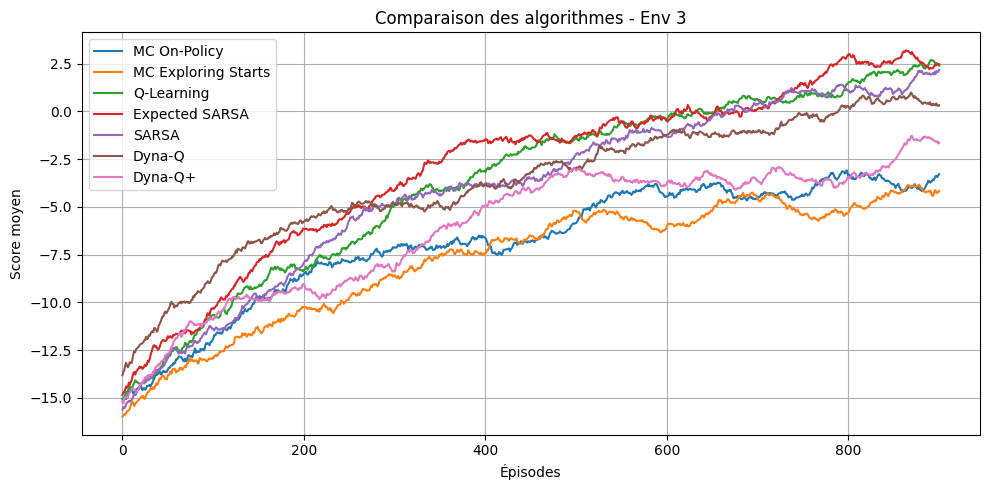

In [12]:
algorithms_data = {
    "MC On-Policy": scores_mc_on_policy,
    "MC Exploring Starts": scores_mc_exploring_starts,
    "Q-Learning": scores_q,
    "Expected SARSA": scores_esarsa,
    "SARSA": scores_sarsa,
    "Dyna-Q": scores_dq,
    "Dyna-Q+": scores_dqplus
}

plot_unified(
    algorithms_data, 
    title="Comparaison des algorithmes - Env 3",
    ylabel="Score moyen",
    window=100
)

In [ ]:
from reinfolearn.algorithm.dp.fast_policy_iteration_sparse import fast_policy_iteration_sparse

env_class = SecretEnv0()
policy, V, history = fast_policy_iteration_sparse(env_class, gamma=0.99, theta=1e-6, use_progress=True, verbose=True)


plot_unified(
    history,
    title="Convergence de la valeur moyenne V",
    xlabel="Itérations",
    ylabel="Mean V"
)

scores = evaluate_policy_score(env_class, policy, n_episodes=100)
print(f"Score moyen sur 100 épisodes : {np.mean(scores):.2f}")

🔁 Extraction transitions:  44%|████▍     | 3634/8192 [04:11<05:15, 14.43it/s]

In [ ]:
from reinfolearn.algorithm.dp.fast_value_iteration import value_iteration

policy, V, delta_history = value_iteration(env_class, use_progress=True)
plot_convergence(delta_history)

scores = evaluate_policy_score(env_class, policy, n_episodes=100)
plot_scores(scores, title="Performance de la politique (VI)")

In [21]:
from reinfolearn.algorithm.dp.fast_policy_iteration_sparse import fast_policy_iteration_sparse

env_class = SecretEnv1()
policy, V, history = fast_policy_iteration_sparse(env_class, gamma=0.99, theta=1e-6, use_progress=True, verbose=True)


plot_unified(
    history,
    title="Convergence de la valeur moyenne V",
    xlabel="Itérations",
    ylabel="Mean V"
)

scores = evaluate_policy_score(env_class, policy, n_episodes=100)
print(f"Score moyen sur 100 épisodes : {np.mean(scores):.2f}")

🔁 Extraction transitions:   4%|▍         | 2943/65536 [50:02<17:44:23,  1.02s/it]


KeyboardInterrupt: 

In [22]:
# policy_pi, V_pi, _ = run_experiment(
#     env_class, policy_iteration, "policy_iteration", env_name,
#     gamma=0.9, theta=0.1, max_iterations=5)
# scores_pi = evaluate_policy_score(env_class(), policy_pi, nb_episodes=500)
# summary_pi = summarize_policy_scores(scores_pi)
# print("Policy Iteration summary:", summary_pi)

In [23]:
# # Pour Value Iteration
# policy_vi, V_vi, _ = run_experiment(
#     env_class, value_iteration, "value_iteration", env_name,
#     gamma=0.9, theta=0.1, max_iterations=5)
# scores_vi = evaluate_policy_score(env_class(), policy_vi, nb_episodes=500)
# summary_vi = summarize_policy_scores(scores_vi)
# print("Value Iteration summary:", summary_vi)